<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Анализ-и-предобработка" data-toc-modified-id="Анализ-и-предобработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ и предобработка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка признаков</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разбиение-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разбиение-на-обучающую-и-тестовую-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбиение на обучающую и тестовую выборки</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение--RandomForestRegressor" data-toc-modified-id="Обучение--RandomForestRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение  RandomForestRegressor</a></span></li><li><span><a href="#Реализация--LGBM-Regressor" data-toc-modified-id="Реализация--LGBM-Regressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Реализация  LGBM Regressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод¶" data-toc-modified-id="Общий-вывод¶-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод¶</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Обзор данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.datasets import load_boston
import warnings
import time

In [2]:
try:
    df = pd.read_csv('/taxi.csv',index_col='datetime')
except:    
    df = pd.read_csv('/datasets/taxi.csv',index_col='datetime')

df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
df.index

Index(['2018-03-01 00:00:00', '2018-03-01 00:10:00', '2018-03-01 00:20:00',
       '2018-03-01 00:30:00', '2018-03-01 00:40:00', '2018-03-01 00:50:00',
       '2018-03-01 01:00:00', '2018-03-01 01:10:00', '2018-03-01 01:20:00',
       '2018-03-01 01:30:00',
       ...
       '2018-08-31 22:20:00', '2018-08-31 22:30:00', '2018-08-31 22:40:00',
       '2018-08-31 22:50:00', '2018-08-31 23:00:00', '2018-08-31 23:10:00',
       '2018-08-31 23:20:00', '2018-08-31 23:30:00', '2018-08-31 23:40:00',
       '2018-08-31 23:50:00'],
      dtype='object', name='datetime', length=26496)

Предоставлены данные за период: 1 марта 2018 по 31 августа 2018. Каждой строчке датафрейма соотвествует количество заказов за 10 минут.

Изучим данные:

In [4]:
print(df.shape)
df.info()

(26496, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0+ KB


Проверяю, что даты идут по порядку:

In [5]:
df.index.is_monotonic

True

## Анализ и предобработка

Выполним почасовой ресеймплинг, предварительно изменив тип на `datetime`:

In [6]:
df.index = pd.to_datetime(df.index)
print(type(df.index))
df = df.resample('1H').sum()
print(df.shape)
df.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
(4416, 1)


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Добавим скользящее стандартное отклонение и среднее:

In [7]:
df['rolling_mean'] = df['num_orders'].rolling(15).mean()
df['rolling_std'] = df['num_orders'].rolling(15).std()

Посмотрим на данные при помощи графиков:

<AxesSubplot:xlabel='datetime'>

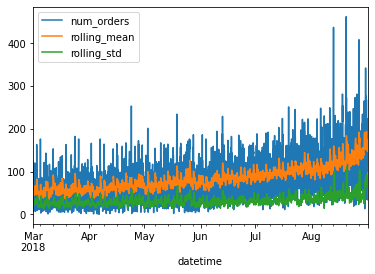

In [8]:
df.plot()

Изначально выборка достаточно стационарна, стандартное отклонение меняется незначительно.


Разложим временной ряд на тренд и сезонную компоненту:

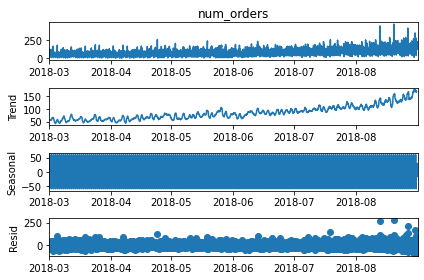

In [9]:
decomposed =  seasonal_decompose(df['num_orders']) 
decomposed.plot();

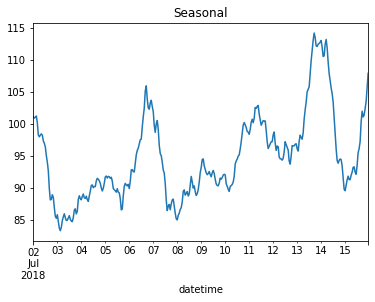

In [10]:
decomposed.trend['2018-07-02' : '2018-07-15'].plot(title='Seasonal');

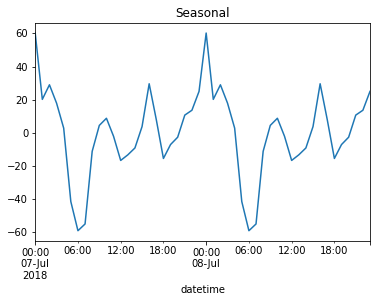

In [11]:
decomposed.seasonal['2018-07-07' : '2018-07-8'].plot(title='Seasonal');

### Вывод

Тренд по кол-ву заказов растущий, предполагаю, что это связано с ростом и развитием самой компании, нежели с сезонностью.

На графике за 2 первые недели июля прослеживантся тренд, связанный с днем недели - рост числа заказов в понедельник, далее спад, и ближе к выходным явный рост.  

График сезонной составляющей за 2 дня июля показал, что наименьшее кол-во заказов с 4 до 7 утра, наибольшее кол-во с 23 до 01 ночи.

## Подготовка признаков

Первоначально удалим дабавленные столбцы, оставив количество заказов:

In [12]:
df = df.drop(['rolling_mean', 'rolling_std'], axis=1)
df.columns

Index(['num_orders'], dtype='object')

### Создание признаков

Создадим и выполниим функцию для создания признаков:

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()    

In [14]:
make_features(df,24,20)

In [15]:
print(df.shape)

(4416, 30)


In [16]:
df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,169.35
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.85
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,157.75


### Разбиение на обучающую и тестовую выборки

Выделим из исходного датафрейма вектор признаков `df_x` (признаки для обучения) и целевой вектор `df_y` (цель для обучения):

In [17]:
df = df.dropna()
df_x = df.drop('num_orders', axis=1)
df_y  = df['num_orders']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1 , shuffle=False)
print("Размер обучающей выборки: {0}; целевой признак {1}:".format(X_train.shape,y_train.shape))
print("Размер валидационной выборки: {0}; целевой признак {1}:".format(X_test.shape,y_test.shape))

Размер обучающей выборки: (3952, 29); целевой признак (3952,):
Размер валидационной выборки: (440, 29); целевой признак (440,):


### Вывод

Признаки созданы, разбиение на обучающую и тестовую выборки выполнено.

## Обучение

Реализуем 2 модели:
- CatBoostRegressor
- LGBMRegressor

Создадим датафрейм для сохранения параметров для сравнения результатов моделей:

In [19]:
results = pd.DataFrame({'name_model' : [], 'score_RMSE_val': '', 'score_RMSE' : [], 'time_learning' : [], 'time_prediction' : []})
results

,name_model,score_RMSE_val,score_RMSE,time_learning,time_prediction


Создадим функцию для расчета значения метрики RMSE:

In [20]:
def mean_squared_error_(predict, target):
    return mean_squared_error(predict, target) ** 0.5
scorer = make_scorer(mean_squared_error_, greater_is_better=False)

### Обучение  RandomForestRegressor

Выполним кросс-валидацию TimeSeriesSplit():

In [21]:
splits = TimeSeriesSplit(n_splits=3)

In [22]:
def random_forest(features, target):
    model_rfr = RandomForestRegressor(random_state=12345)
    parameters = {'n_estimators': range (30,100,10), # задаем гиперпараметры: кол-во деревьев от 30 до 100 с шагом 10
                  'min_samples_split': range (2,5,1), # задаем гиперпараметры: мин. кол-во объектов в узле от 2 до 5 с шагом 1
                  'max_depth': range (4,11,2), # задаем гиперпараметры: максимальная глубина дерева от 4 до 10 с шагом 2
                  'min_samples_leaf': range (1,6)} # задаем гиперпараметры: мин. кол-во объектов в листе от 1 до 5 с шагом 1                  
    random_search =  RandomizedSearchCV(estimator = model_rfr,
                                        param_distributions = parameters,
                                        cv = splits,
                                        scoring = scorer, # задаем mean_squared_error_ в качестве метрики
                                        n_jobs=3)                                     
    random_search.fit(features, target)
    best_parameters = random_search.best_params_
    best_score = random_search.best_score_

    return best_parameters, best_score  

In [23]:
%%time
params_rf, score_rf = random_forest(X_train, y_train)

CPU times: user 1.49 s, sys: 84.7 ms, total: 1.57 s
Wall time: 25.7 s


In [24]:
best_score_rfr = round(abs(score_rf),2)
print('Лучший RMSE:', best_score_rfr)
print('Лучшие параметры модели', params_rf)

Лучший RMSE: 28.15
Лучшие параметры модели {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 8}


Создадим модель с найденными наилучшими параметрами, обучим и проверим на обучающей выборке:

In [25]:
rf_model =  RandomForestRegressor(random_state=12345, n_estimators = 60, min_samples_split = 2, 
                                          min_samples_leaf = 1, max_depth = 10)
start_time = time.time()
rf_model.fit(X_train,y_train)
fit_time = time.time()
predict_train = rf_model.predict(X_train)
predict_time = time.time()
rf_rmse = mean_squared_error_(predict_train, y_train)
rf_fit_time = round(fit_time - start_time,2)
rf_predict_time = round(predict_time - fit_time,2)
print(f'RMSE:', rf_rmse) #linear_RMSE)
print(f'Time_learning:',rf_fit_time)
print(f'time_rediction:',rf_predict_time)

RMSE: 14.655054513328238
Time_learning: 2.07
time_rediction: 0.03


Сохраним полученные результаты:

In [26]:
results = results.append({'name_model' : 'RandomForestRegressor', 'score_RMSE_val' :best_score_rfr,
                          'score_RMSE' : rf_rmse, 'time_learning' : rf_fit_time, 'time_prediction' : rf_predict_time},
                         ignore_index=True)
results

,name_model,score_RMSE_val,score_RMSE,time_learning,time_prediction
0,RandomForestRegressor,28.15,14.655055,2.07,0.03


### Реализация  LGBM Regressor

Для LGBM Regressor выполним кросс-валидацию:

In [42]:
lgbm_train_data = lgb.Dataset(X_train, y_train)
params = {'learning_rate': 1,
         'metric': 'rmse',
         'objective': 'regression',
         'verbosity': -1 ,
         'max_depth':10, "random_state": 42, "learning_rate":0.1
        }

In [43]:
tss = TimeSeriesSplit(3) 
folds = tss.split(X_train) 
cv_results = lgb.cv(params, lgbm_train_data, num_boost_round=10, folds=folds, verbose_eval=False) 
best_cv_score = min(cv_results['rmse-mean'])

In [44]:
print('Лучший RMSE:', best_cv_score)

Лучший RMSE: 31.992560267183006


Обучим модель:

In [45]:
%%time
lgbm_model = lgb.train(params, lgbm_train_data)

CPU times: user 1.23 s, sys: 7.88 ms, total: 1.24 s
Wall time: 1.13 s


In [46]:
%%time

lgbm_predict = lgbm_model.predict(X_train)
lgbm_RMSE = round(mean_squared_error(y_train, lgbm_predict)**0.5, 2)
    
print('LGBMRegressor RMSE:',lgbm_RMSE)

LGBMRegressor RMSE: 12.8
CPU times: user 37.2 ms, sys: 128 µs, total: 37.3 ms
Wall time: 8.36 ms


Сохраним полученные результаты:

In [48]:
results = results.append({'name_model' : ' LGBM Regression', 'score_RMSE_val' : best_cv_score, 'score_RMSE' : lgbm_RMSE,
                'time_learning' : 1.13, 'time_prediction' : 0.00836}, ignore_index=True)
results

,name_model,score_RMSE_val,score_RMSE,time_learning,time_prediction
0,RandomForestRegressor,28.15000,14.655055,2.07,0.03000
1,LGBM Regression,31.99256,12.800000,1.13,0.00836


### Вывод

Посмотрим результуриющую таблицу:

In [50]:
results.sort_values('score_RMSE_val', ascending=True)

,name_model,score_RMSE_val,score_RMSE,time_learning,time_prediction
0,RandomForestRegressor,28.15000,14.655055,2.07,0.03000
1,LGBM Regression,31.99256,12.800000,1.13,0.00836


Из таблицы сразу видно, что модель RandomForestRegressor показала лучший RMSE на кросс-валидации,но по скорости обучения  и предсказания медленнее.

Протестируем данную модель.

## Тестирование

Запустим обученную модель RandomForestRegressor на на тестовом наборе.

In [51]:
%%time
predict = rf_model.predict(X_test)
rf_rmse = mean_squared_error_(predict, y_test)
print(f'RMSE:', rf_rmse)


RMSE: 44.322668165676426
CPU times: user 13.9 ms, sys: 153 µs, total: 14.1 ms
Wall time: 12.2 ms


Итоговые результаты RandomForestRegressor:

- качество предсказания RMSE: 44.32
- скорость предсказания: 12.2 ms

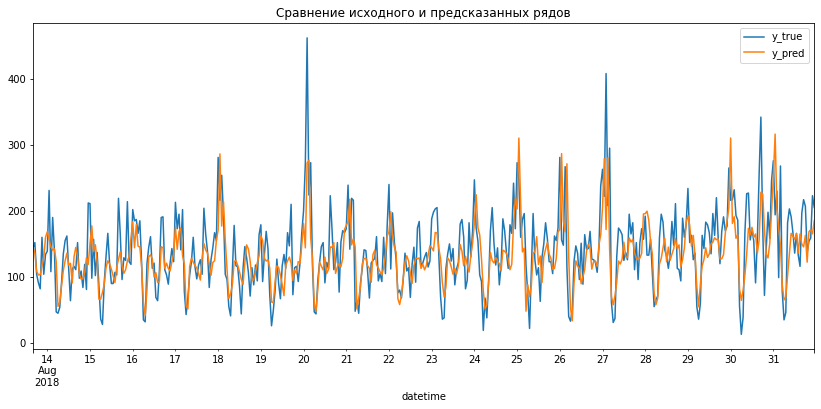

In [52]:
true_pred = pd.DataFrame({ 
    'y_true' : y_test,
    'y_pred' : predict
    })

true_pred.plot(figsize=(14,6), title='Сравнение исходного и предсказанных рядов');

Предсказания выполнены достаточно точно: графики практически дублирует друг друга. Можно заменить, что предсказания имееют меньшую амплитуду колебания, чем истинные значения. Это объясняется усреднением результатов множество решающих деревьев.

## Общий вывод¶

В данном проекте была найдена лучшая регрессионная модель для прогнозирования количество заказов такси на следующий час для компании «Чётенькое такси».

Первоначально были предоставлены данные  за период: 1.03-31.08 2018 года, в каждой строке было записано количество заказов за 10 минут. Был выполнен почасовой ресеймплинг, для удобства дальнейшей анализа. 

Разложив временной ряд на тренд и сезонную компоненту, было выявлено:
 - тренд по кол-ву заказов растущий;
 - сезонности по месяцам у такси нет;
 - сезонность выражена в заказах внутри дня, по часам.


Создали новые признаки:
- четыре календарных признака: год, месяц, день и день недели;
- получили отстающие значения знакомой функцией shift (максимальный размер отставания 20);
- вычислили скользящее среднее (ширина окна 24).

Разбили выборку на обучающую и тестовую (90/10). 

Были обучены 2 модели:
- RandomForestRegressor
- LGBMRegressor.

Для каждой из моделей было измерено:
- качество предсказания (RMSE);
- время обучения (время выполнения fit);
- скорость предсказания (время выполнения predict).

На валидационной выборке лучший RMSE показала модель RandomForestRegressor, для которой было выполнено тестирование. 
Значение метрики RMSE на тестовой выборке должно быть не больше 48 - метрика достигнута.

**Рекомендую к использованию RandomForestRegressor, так как модель удовлетворяет заявленной оценки.**